In [19]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from contextily import add_basemap
from rasterio import windows
from scipy.stats import mode
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic

In [3]:
# Data parameter
s1_aceh_before = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/aceh_2025-11-21_S1_RTC_composite_2025-11-20_2025-11-22_10m.tif"
s1_aceh_after = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/aceh_2025-11-28_S1_RTC_composite_2025-11-27_2025-11-29_10m.tif"
s1_sumatera_utara_before = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/sumatera_utara_2025-11-21_S1_RTC_composite_2025-11-20_2025-11-22_10m.tif"
s1_sumatera_utara_after = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/sumatera_utara_2025-11-28_S1_RTC_composite_2025-11-27_2025-11-29_10m.tif"
s1_sumatera_barat_before = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/sumatera_barat_2025-11-21_S1_RTC_composite_2025-11-20_2025-11-22_10m.tif"
s1_sumatera_barat_after = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/sumatera_barat_2025-11-28_S1_RTC_composite_2025-11-27_2025-11-29_10m.tif"
roi = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/rois/flood_sumatera_roi_2025-11-28.geojson"

In [4]:
# Data dictionary
data_dict = [
    dict(
        provinsi="Aceh",
        period=[
            dict(name="Before", date="2025-11-21", s1=s1_aceh_before),
            dict(name="After", date="2025-11-28", s1=s1_aceh_after),
        ],
    ),
    dict(
        provinsi="Sumatera Utara",
        period=[
            dict(name="Before", date="2025-11-21", s1=s1_sumatera_utara_before),
            dict(name="After", date="2025-11-28", s1=s1_sumatera_utara_after),
        ],
    ),
    dict(
        provinsi="Sumatera Barat",
        period=[
            dict(name="Before", date="2025-11-21", s1=s1_sumatera_barat_before),
            dict(name="After", date="2025-11-28", s1=s1_sumatera_barat_after),
        ],
    ),
]

,id,name,provinsi,geometry
0,1,Padang Tiji,Aceh,"MULTIPOLYGON (((95.78337 5.24725, 95.78337 5.4..."
1,2,Sigli,Aceh,"MULTIPOLYGON (((95.48551 5.29529, 95.48551 5.4..."
2,3,Lhokseumawe,Aceh,"MULTIPOLYGON (((96.99152 5.08081, 96.99152 5.2..."
3,4,Meulaboh,Aceh,"MULTIPOLYGON (((95.89164 4.0903, 95.89164 4.45..."
4,5,Darul Makmur,Aceh,"MULTIPOLYGON (((96.30719 3.75188, 96.30719 4.1..."
5,6,Aceh Selatan,Aceh,"MULTIPOLYGON (((97.25772 2.98578, 97.25772 3.2..."
6,7,Aceh Singkil,Aceh,"MULTIPOLYGON (((97.74395 2.26921, 97.74395 2.4..."
7,8,Rundeng,Aceh,"MULTIPOLYGON (((97.73094 2.59992, 97.73094 2.8..."
8,9,Pante Beudari,Aceh,"MULTIPOLYGON (((97.32231 4.74472, 97.32231 5.0..."
9,10,Pante Peureulak,Aceh,"MULTIPOLYGON (((97.58087 4.56014, 97.58087 4.8..."


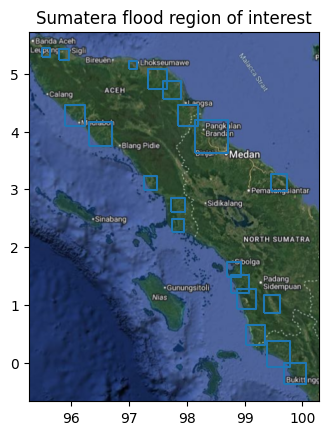

In [28]:
# Plot region of interest
df_roi = gpd.read_file(roi)
ax = df_roi.boundary.plot()
add_basemap(
    ax,
    crs="EPSG:4326",
    source="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}",
)
ax.set_title("Sumatera flood region of interest")
df_roi

In [29]:
def generate_flood(y, fig):
    roi_select = df_roi.iloc[y : y + 1]
    location = roi_select.iloc[0]["name"]
    province = roi_select.iloc[0]["provinsi"]

    # get provinsi info
    data_provinsi = [info for info in data_dict if info["provinsi"] == province][0]
    period_info = data_provinsi["period"]

    print(f"Processing {location}")
    bbox = tuple(roi_select.total_bounds)
    min_x, min_y, max_x, max_y = bbox
    layer_extent = (min_x, max_x, min_y, max_y)

    # define ideal shape
    resolution = 30
    width = int(abs(bbox[0] - bbox[2]) * 111_000 / resolution)
    height = int(abs(bbox[1] - bbox[3]) * 111_000 / resolution)
    shape = (height, width)

    # data dict after clip
    images = dict()

    # load data per period
    for x in range(len(period_info)):
        data_info = period_info[x]
        name = data_info["name"]
        date = data_info["date"]
        path = data_info["s1"]

        # load sentinel-1 image image
        with rio.open(path) as src:
            window = windows.from_bounds(*bbox, transform=src.transform)
            s1 = src.read(window=window, out_shape=shape)
            vv, vh = s1
            rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
            composite_s1 = np.dstack(
                [
                    rescale_intensity(vv, in_range=(1000, 3000), out_range=(0, 255)),
                    rescale_intensity(vh, in_range=(0, 1000), out_range=(0, 255)),
                    rescale_intensity(rdi, in_range=(0.5, 1), out_range=(0, 255)),
                ]
            ).astype("uint8")

            # plot sentinel-1 image
            ax = fig.add_subplot(
                len(df_roi),
                3,
                y * 3 + x + 1,
            )
            ax.set_title(f"{location}, {province} ({date})")
            ax.imshow(composite_s1, extent=layer_extent)

            # generate water mask
            water = (vv < 1000) * (vh < 500) * 1
            segment = slic(composite_s1 / 255, n_segments=10000, compactness=5, sigma=5)
            unique = np.unique(segment)
            water_segment = segment.copy()

            for val in unique:
                water_segment[segment == val] = mode(water[segment == val], axis=0).mode

            images[name] = dict(vv=vv, vh=vh, rdi=rdi, water=water_segment)

    # Flood map
    flood_map = (
        (images["Before"]["water"] == 0) * (images["After"]["water"] == 1)
    ).astype("float32")
    flood_area = (np.sum(flood_map) * (resolution**2) / 10_000).astype("uint32")
    flood_map = flood_map.astype("float32")
    flood_map[flood_map == 0] = np.nan

    # Plot flood map
    ax3 = fig.add_subplot(
        len(df_roi),
        3,
        y * 3 + 3,
    )
    ax3.set_title(
        f"Flood {location}, {province}: {(f'{flood_area:,}').replace(',', ' ')} Ha"
    )
    ax3.imshow(
        flood_map,
        extent=layer_extent,
        cmap="Blues",
        zorder=9999,
        vmin=0,
        vmax=2,
    )
    add_basemap(
        ax=ax3,
        crs="EPSG:4326",
        source="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}",
    )

In [ ]:
fig = plt.figure(figsize=(15, 5 * len(df_roi)))

with ThreadPoolExecutor(16) as executor:
    jobs = []

    # selected_roi
    for y in range(len(df_roi)):
        jobs.append(executor.submit(generate_flood, y, fig))

    for job in jobs:
        try:
            job.result()
        except Exception as e:
            print(f"Error: {e}")

plt.show(fig)

Processing Padang Tiji
Processing Sigli
Processing Lhokseumawe
Processing Meulaboh
Processing Darul Makmur
Processing Aceh Selatan
Processing Aceh Singkil
Processing Rundeng
Processing Pante Beudari
Processing Pante Peureulak
Processing Kuala Simpang
Processing Pandan
Processing Batangtoru
Processing Singkuang
Processing Mandailing Natal
Processing Tapanuli Selatan


C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:36: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:43: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")


Processing Tanjung Tiram


C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:36: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:43: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")


Processing Tanjung Pura


C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:36: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:43: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")


Processing Pasaman Barat


C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:36: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:43: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")


Processing Agam


C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:36: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_27080\4061147846.py:43: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")
